# Using DeconvNet Visualizations for improving Model Architecture selection

Tuning parameters of a CNN's architecture like the sizes of filters, padding sizes, strides, etc. can be quite a difficult task.

We can use visualizations of the activations in each layer to get a better understanding of what exactly a layer "sees" in the image and use that understanding to tune the model's architecture to improve the accuracy of a model.


In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
from torchvision.transforms import transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

### Functions for visualizing layer activations

In [2]:
# Gives the DeconvNet corresponding to a layer of a model (specified by its index)
# as well as the output from that layer

def getDeconvModel(model, input_img, last_layer_index):
    
    layer_list = []
    unpool_indices_list = []

    x = input_img

    for idx, layer in enumerate(model.features):

        if isinstance(layer, torch.nn.Conv2d):
            B, C, H, W = x.shape
            x = layer(x)
            deconv_layer = torch.nn.ConvTranspose2d(layer.out_channels, C, layer.kernel_size, layer.stride, layer.padding)
            deconv_layer.weight = layer.weight
            layer_list.append(deconv_layer)

        if isinstance(layer, torch.nn.ReLU):
            x = layer(x)
            layer_list.append(layer)

        if isinstance(layer, torch.nn.MaxPool2d):
            layer.return_indices = True
            x, unpool_index = layer(x)
            unpool_indices_list.append(unpool_index)
            unpool_layer = torch.nn.MaxUnpool2d(kernel_size=layer.kernel_size, stride=layer.stride,
                                                padding=layer.padding)
            layer_list.append(unpool_layer)
            layer.return_indices = False

        if idx == last_layer_index:
            break

    def deconvNet(y):
        for layer in reversed(layer_list):
            if isinstance(layer, torch.nn.MaxUnpool2d):
                y = layer(y, unpool_indices_list.pop())
            else:
                y = layer(y)
        return y

    return x, deconvNet

### Downloading the MNIST Dataset and visualizing a sample



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))]
)

batch_size = 25

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



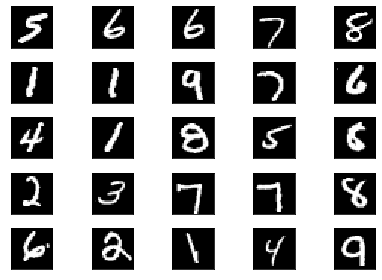

In [4]:
# Visualizing a sample from the dataset

data_iter = iter(trainloader)
images, labels = data_iter.next()

fig = plt.figure()
for i,image in enumerate(images):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i][0], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

### Functions for training and testing

In [5]:
def train(model, dataloader, num_epoch=5):
    momentum = 0.9
    lr = 1e-3
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    losses = []
    e = [i+1 for i in range(num_epoch)]

    for t in range(num_epoch):
        running_loss = 0
        total_images = 0
        correct_images = 0
        
        for i, data in enumerate(dataloader):
            images, labels = data

            optimizer.zero_grad()
            outputs = model(images)
            _, predicts = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_images += labels.size(0)
            correct_images += (predicts == labels).sum().item()
            loss_data = loss.item()
            running_loss += loss_data
            
        print('Epoch %d loss: %.6f, Training accuracy: %.5f' %
                (t + 1, running_loss / 2000, 100 * correct_images / total_images))

        losses.append(running_loss)

    print('Finished training.')

    plt.plot(e, losses, color='red', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.show()

In [6]:
def test(model, dataloader):
    total_images = 0
    correct_images = 0

    for i, data in enumerate(dataloader):
        images, labels = data
        outputs = model(images)
        _, predicts = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        correct_images += (predicts == labels).sum().item()

    print(f"Test Accuracy: {100 * correct_images / total_images}")


### Defining the original model

Here, we define a CNN which we will train on our dataset and visualize activations for a few of the samples. Based on the observations from the activations, we will make changes to this model to hopefully improve performance.

In [7]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=10, stride = 4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=5, stride = 2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )      

        self.classifier = nn.Linear(32, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.classifier(x)
        return x

model1 = CNN1()
print(model1)

CNN1(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(10, 10), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Linear(in_features=32, out_features=10, bias=True)
)


### Training and testing 

Epoch 1 loss: 0.650650, Training accuracy: 84.76000
Epoch 2 loss: 0.187973, Training accuracy: 95.14667
Epoch 3 loss: 0.141548, Training accuracy: 96.38500
Epoch 4 loss: 0.118200, Training accuracy: 96.97500
Epoch 5 loss: 0.103576, Training accuracy: 97.34333
Finished training.


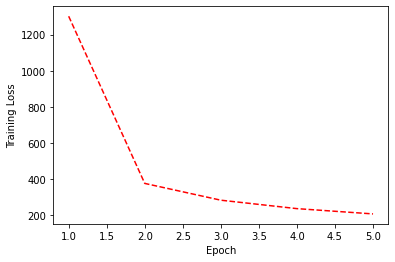

Test Accuracy: 97.2


In [9]:
train(model1, trainloader, 5)
test(model1, testloader)

In [11]:
# Saving the model
torch.save(model1.state_dict(), "./drive/My Drive/smai/mnistPoor.pt")

### Visualizing activations of original model

In [14]:
# Get a sample from dataset
images, labels = iter(trainloader).next()
image = images[0]

# Conv layer 1
y, deconvnet = getDeconvModel(model1, images, 0)
activations1 = deconvnet(y)

# Con layer 2
y, deconvnet = getDeconvModel(model1, images, 3)
activations2 = deconvnet(y)

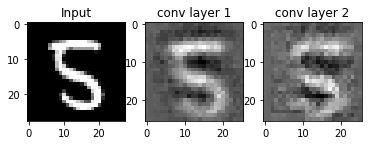

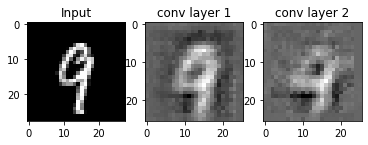

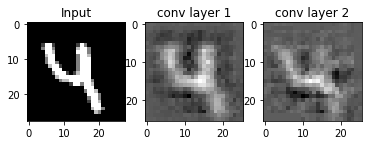

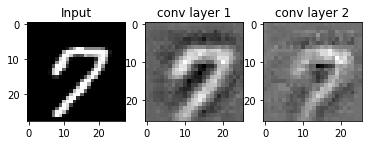

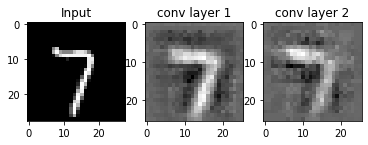

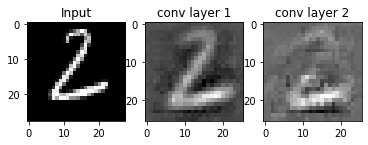

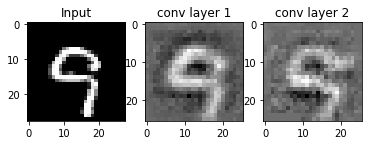

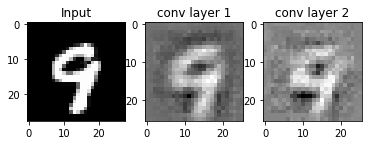

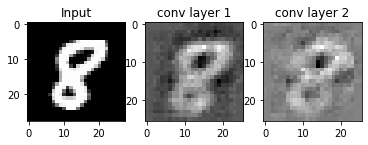

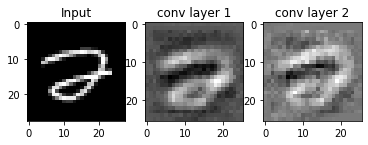

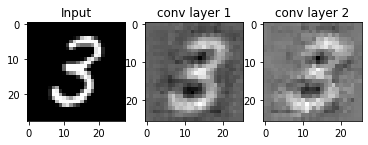

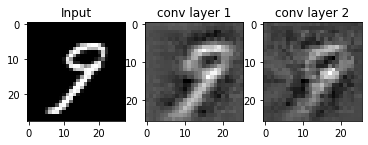

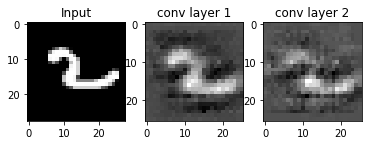

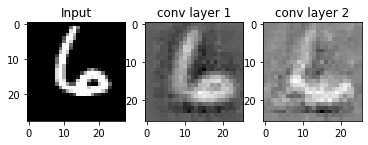

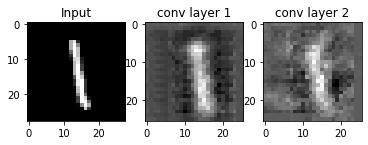

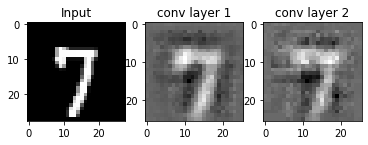

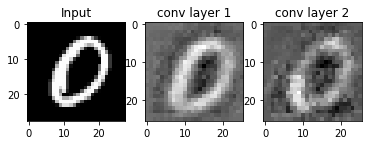

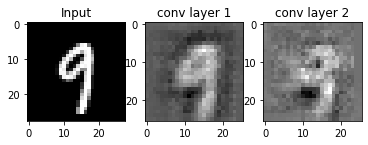

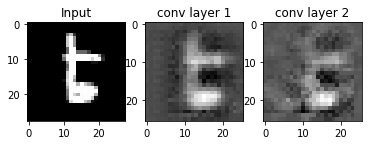

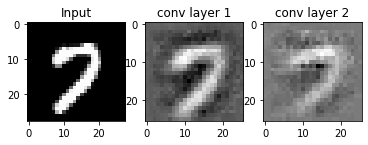

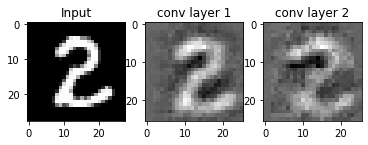

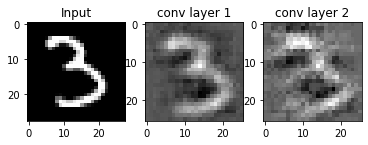

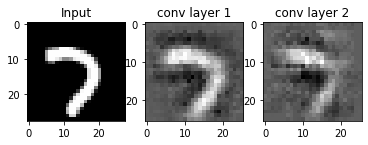

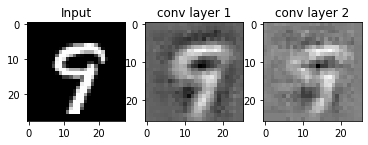

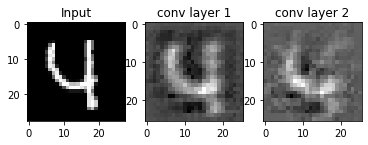

In [15]:

for idx, (image, activ1, activ2) in enumerate(zip(images, activations1, activations2)):

    fig = plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(image[0], cmap='gray')
    plt.title("Input")

    plt.subplot(1, 3, 2)
    plt.imshow(activ1[0].detach().numpy(), cmap='gray')
    plt.title("conv layer 1")

    plt.subplot(1, 3, 3)
    plt.imshow(activ2[0].detach().numpy(), cmap='gray')
    plt.title("conv layer 2")

    plt.show()
    print()


### Observations

As our attempt has been to replicate the results in the paper, we too report similar observations in the feature visualizations.

**Aliasing:** Prominent aliasing artifacts are visible in the features of both convolution layers, especially the second layer. Ideally, we would want that the feature activations are strong in the region of the handwritten digits' strokes and very weak outside of it with the differencee between these two being high. However we see that there is a clear aliasing effect giving the empression of softer boundaries. This is caused by large strides and we attempt to fix that by reducing the strides in the improved model. We also reduce kernel size.

### Improved model

In [16]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride = 1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=5, stride = 1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )      

        self.classifier = nn.Linear(1568, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.classifier(x)
        return x

model2 = CNN2()
print(model2)

CNN2(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Linear(in_features=1568, out_features=10, bias=True)
)


Epoch 1 loss: 0.287375, Training accuracy: 93.04500
Epoch 2 loss: 0.091878, Training accuracy: 97.73667
Epoch 3 loss: 0.068334, Training accuracy: 98.26500
Epoch 4 loss: 0.056984, Training accuracy: 98.49833
Epoch 5 loss: 0.048687, Training accuracy: 98.73833
Finished training.


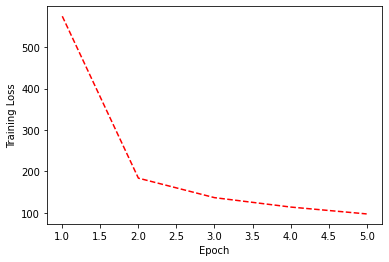

Test Accuracy: 98.72


In [17]:
train(model2, trainloader, num_epoch=5)
test(model2, testloader)

### Visualization of improved model

In [19]:
# Get a sample from dataset
images, labels = iter(trainloader).next()
image = images[0]

# Conv layer 1
y, deconvnet = getDeconvModel(model2, images, 0)
activations1 = deconvnet(y)

# Con layer 2
y, deconvnet = getDeconvModel(model2, images, 3)
activations2 = deconvnet(y)

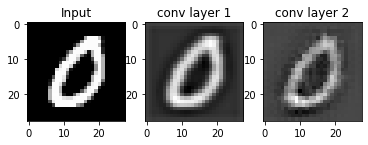

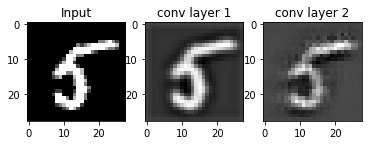

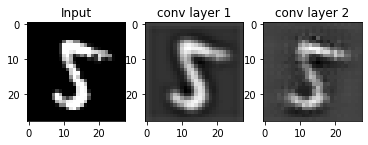

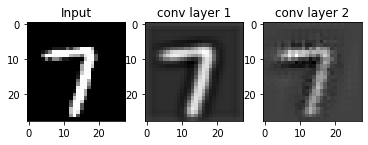

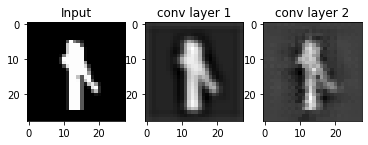

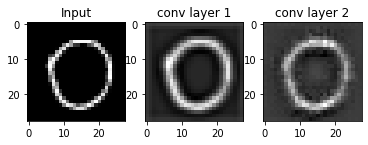

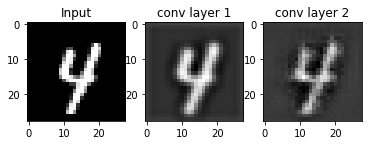

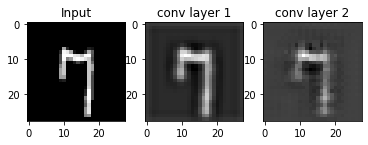

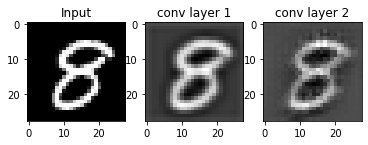

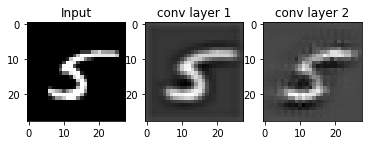

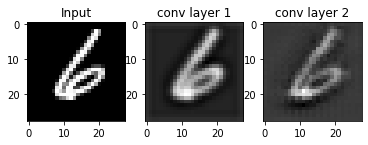

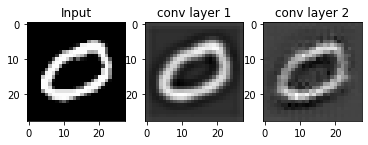

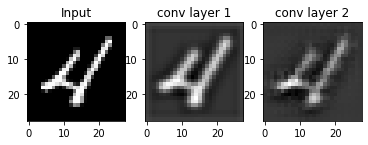

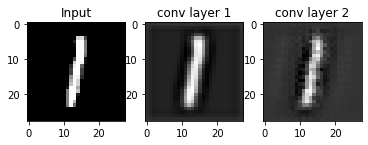

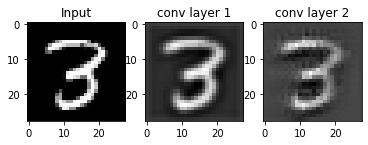

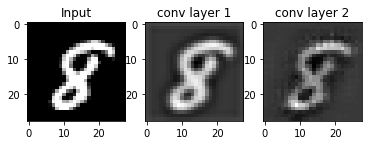

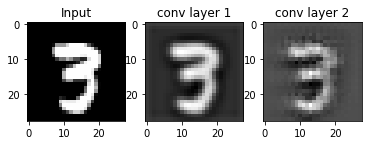

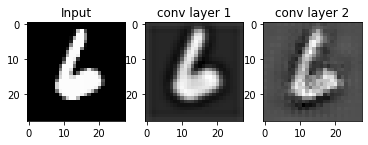

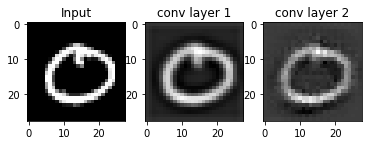

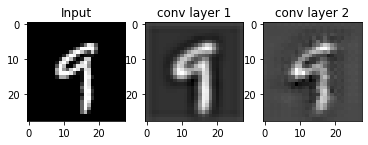

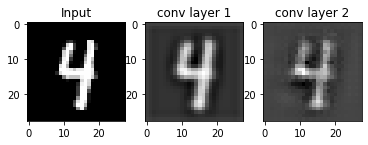

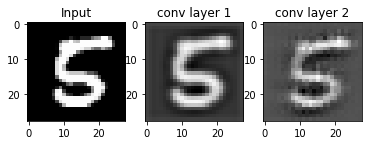

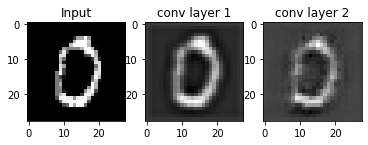

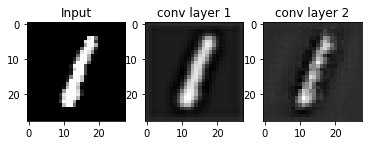

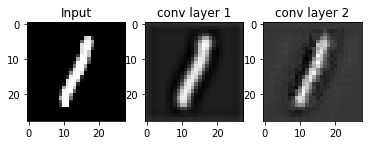

In [20]:

for idx, (image, activ1, activ2) in enumerate(zip(images, activations1, activations2)):

    fig = plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(image[0], cmap='gray')
    plt.title("Input")

    plt.subplot(1, 3, 2)
    plt.imshow(activ1[0].detach().numpy(), cmap='gray')
    plt.title("conv layer 1")

    plt.subplot(1, 3, 3)
    plt.imshow(activ2[0].detach().numpy(), cmap='gray')
    plt.title("conv layer 2")

    plt.show()
    print()

### Conclusions

We see a reduction in the aliasing effect in both layers with the boundary between the stroke and background being much less smoother.

Also, we see an improvement in the model accuracy which confirms that our tuning of architecture parameters was a step in the right direction.